In [1]:
dataset <- "ARPAV"
merging_datasets <- c(dataset, "SCIA")
state <- "Veneto"
match_dist <- 15000
new_dataset <- "VEN"

In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Lombardia", "Trentino-Alto Adige", "Friuli-Venezia Giulia", "Emilia-Romagna")), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [8]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"))


In [13]:
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = TRUE)
    # tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


In [16]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 10L, 0.5)


In [17]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))
i

pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>


In [18]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 1)
db <- merged_checkpoint(merge_results, metadata, new_dataset)
rm(merge_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2173684,116.1,3879177,207.2,NA,3879177,207.2
Vcells,22810276,174.1,102187818,779.7,16384,199585579,1522.8


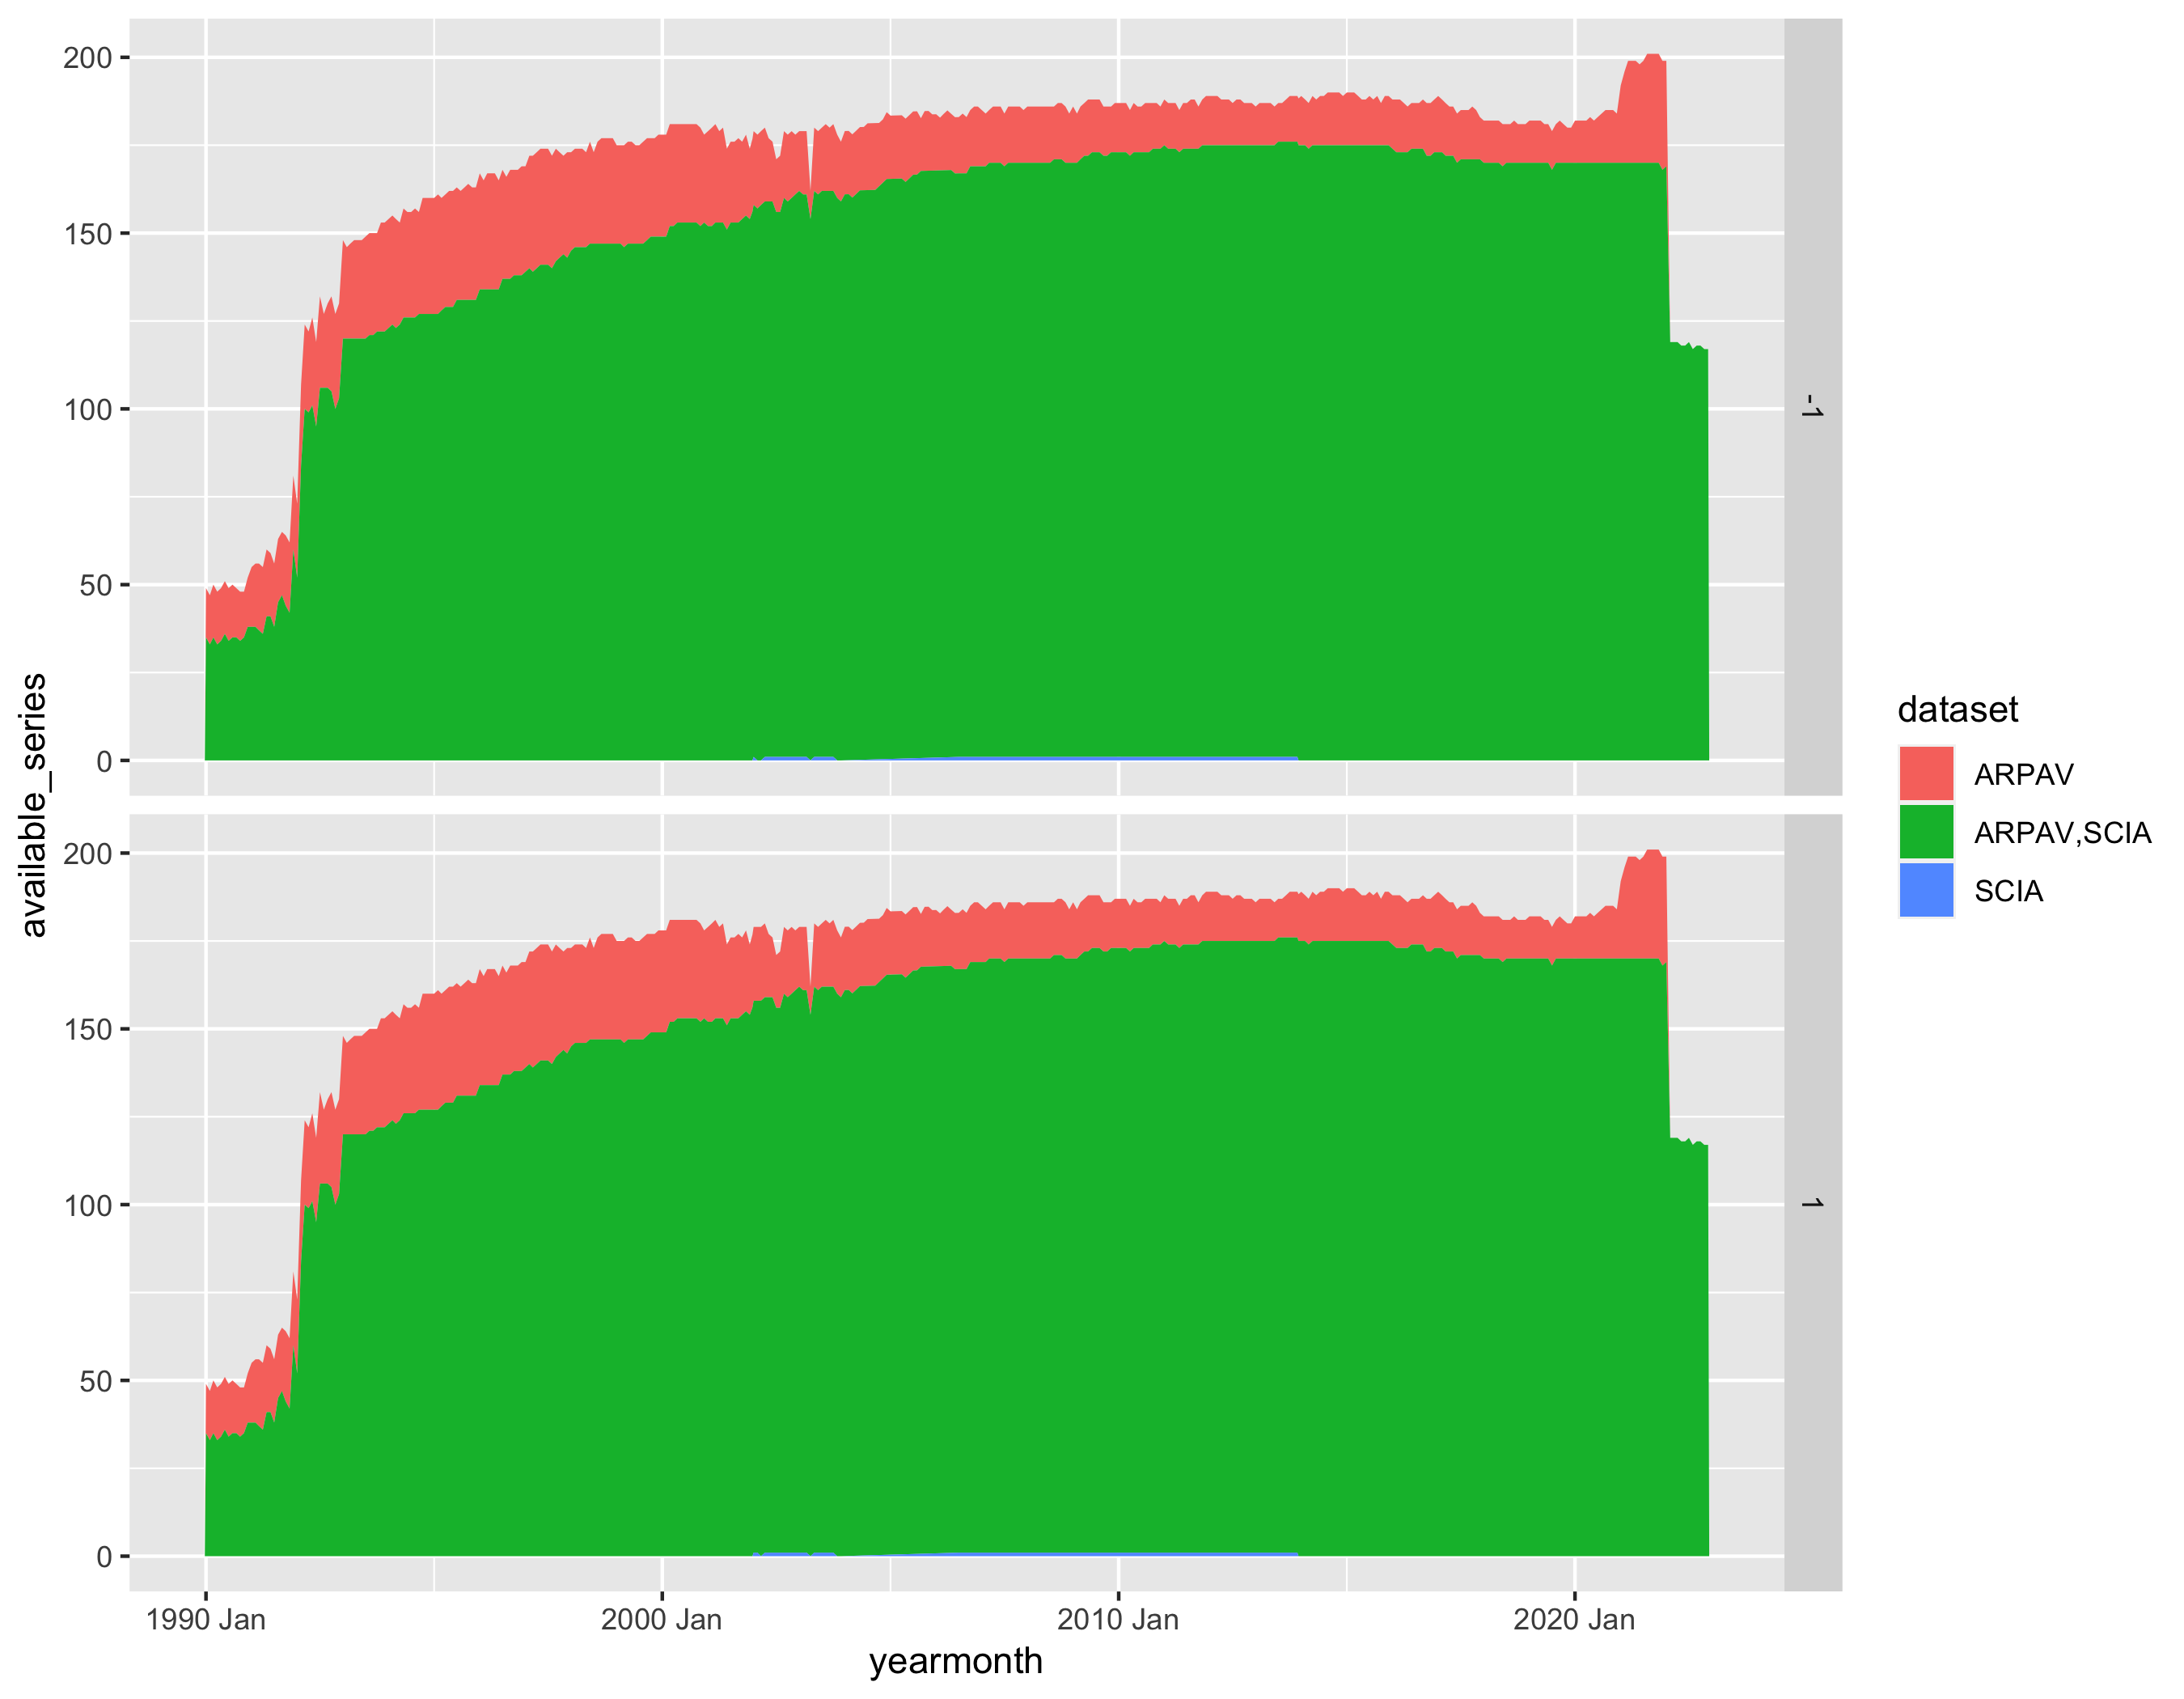

In [23]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)

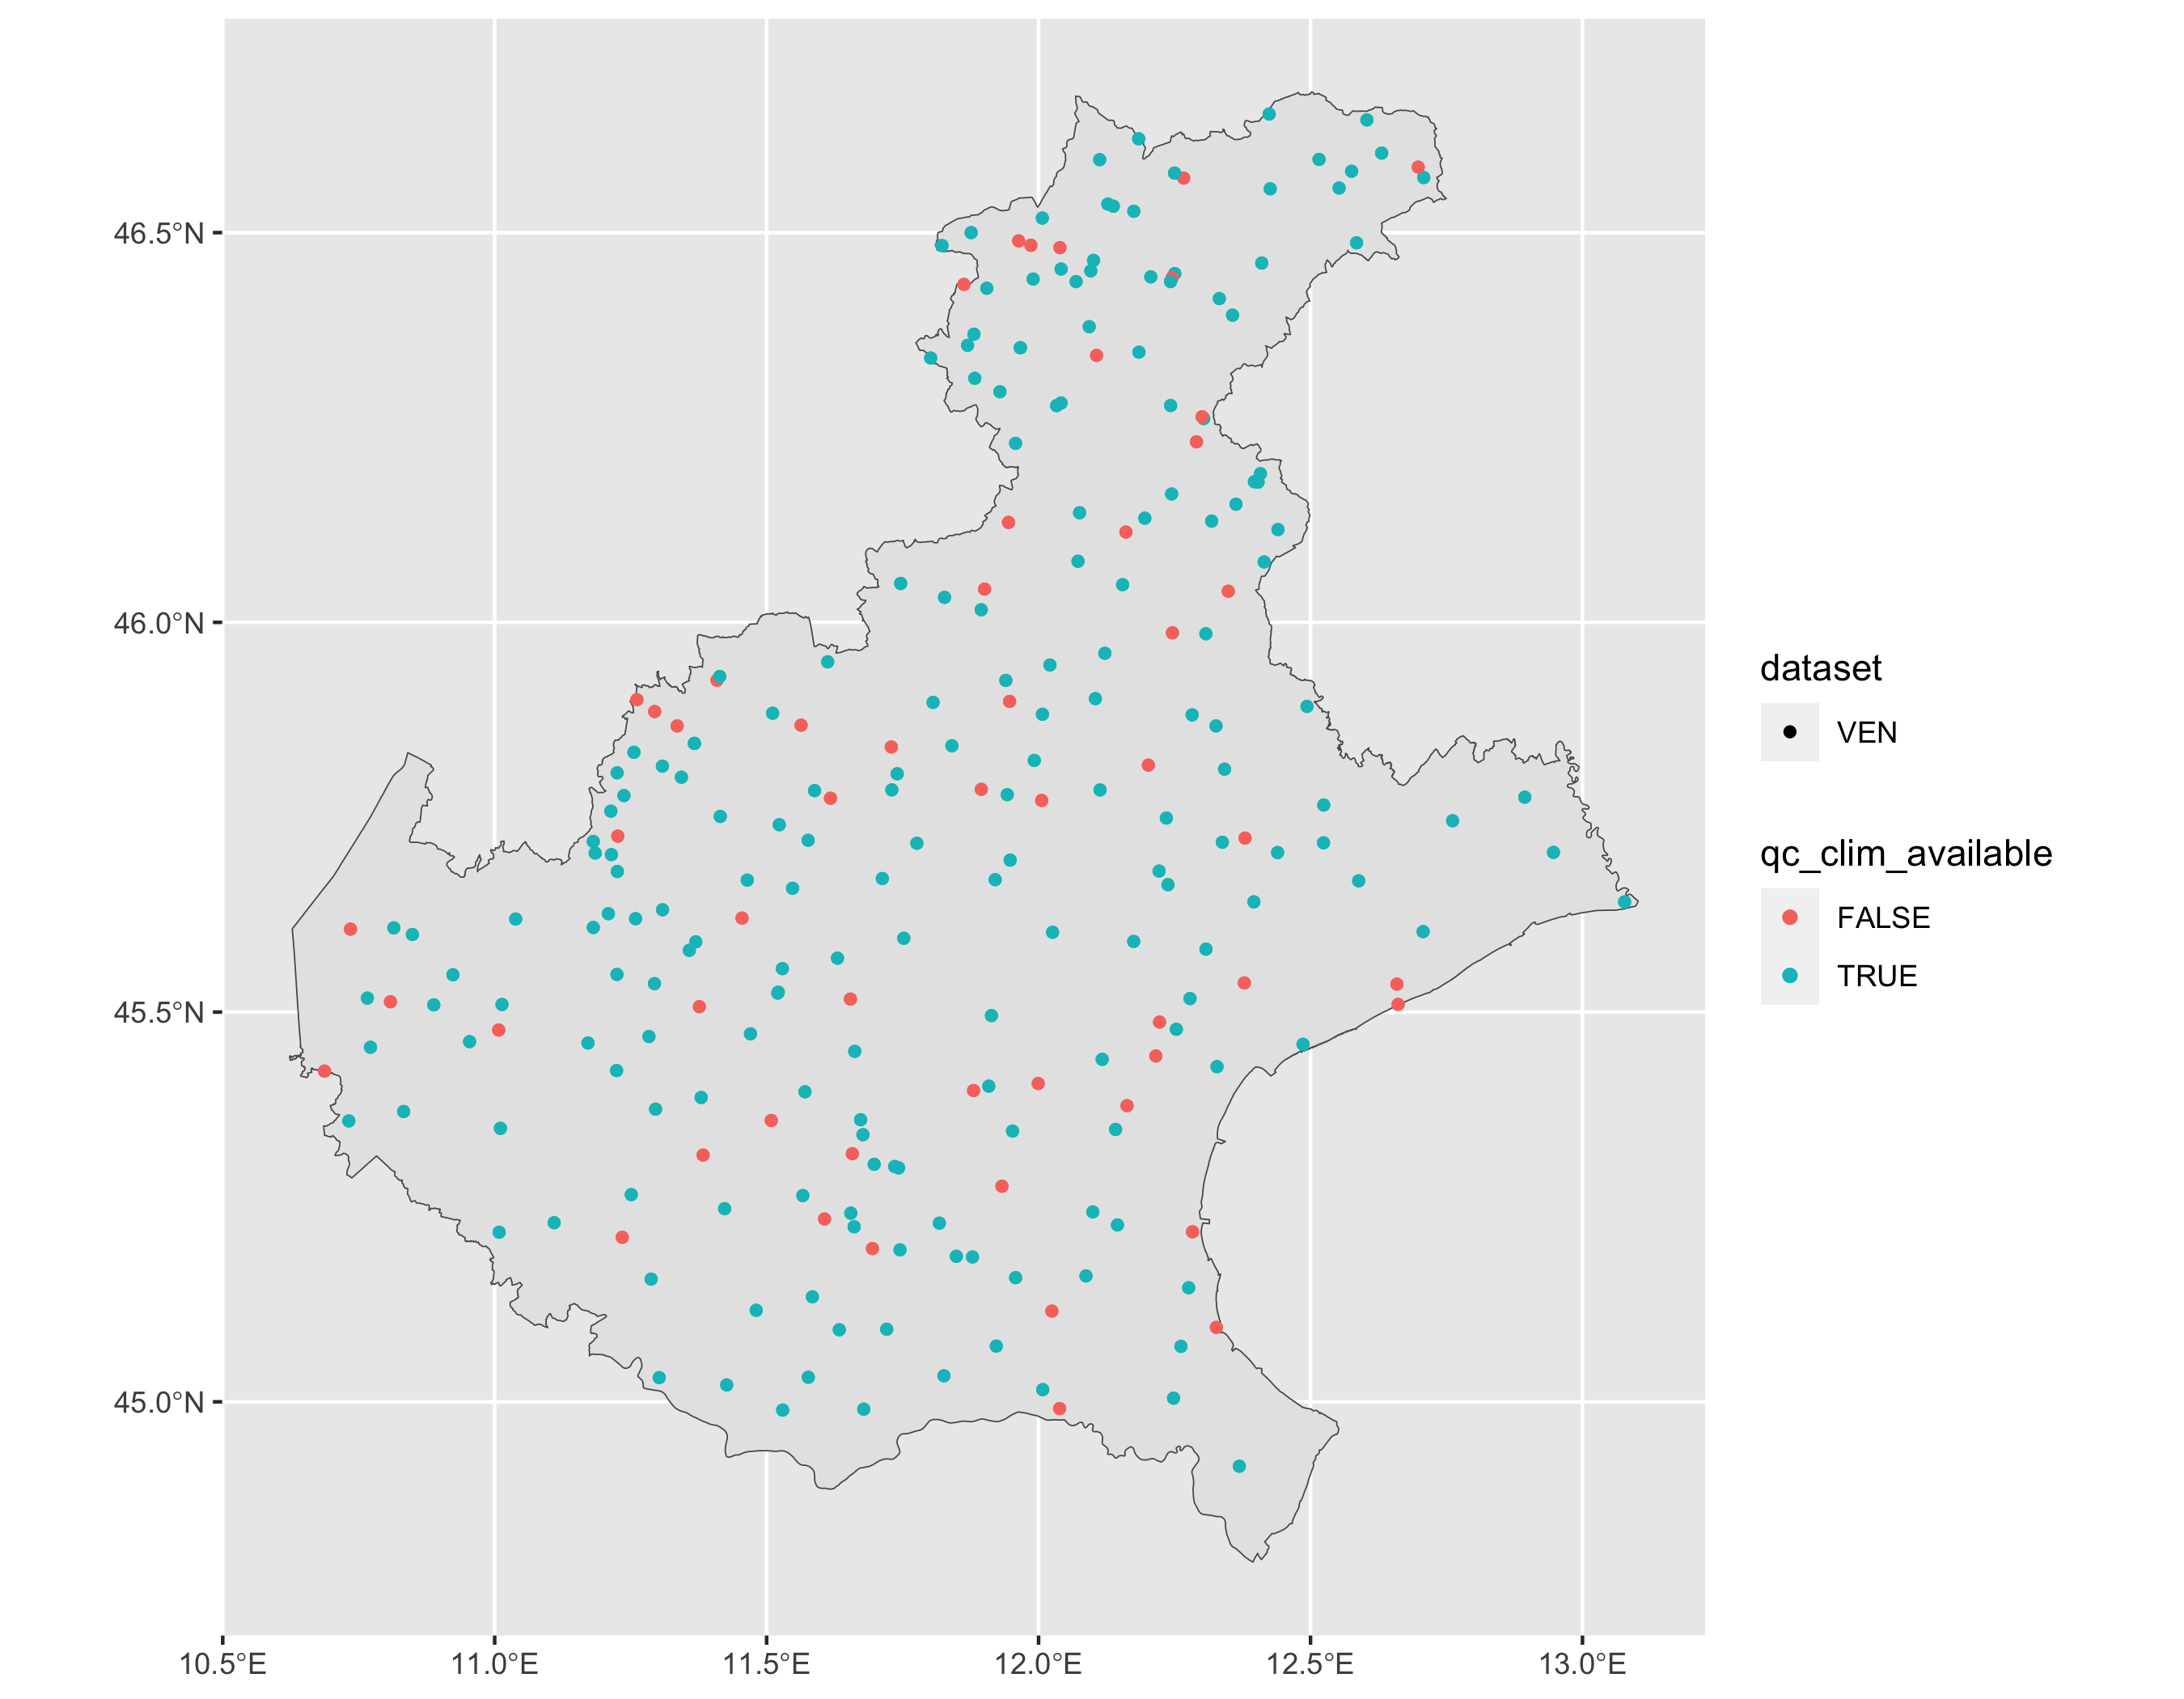

In [24]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot

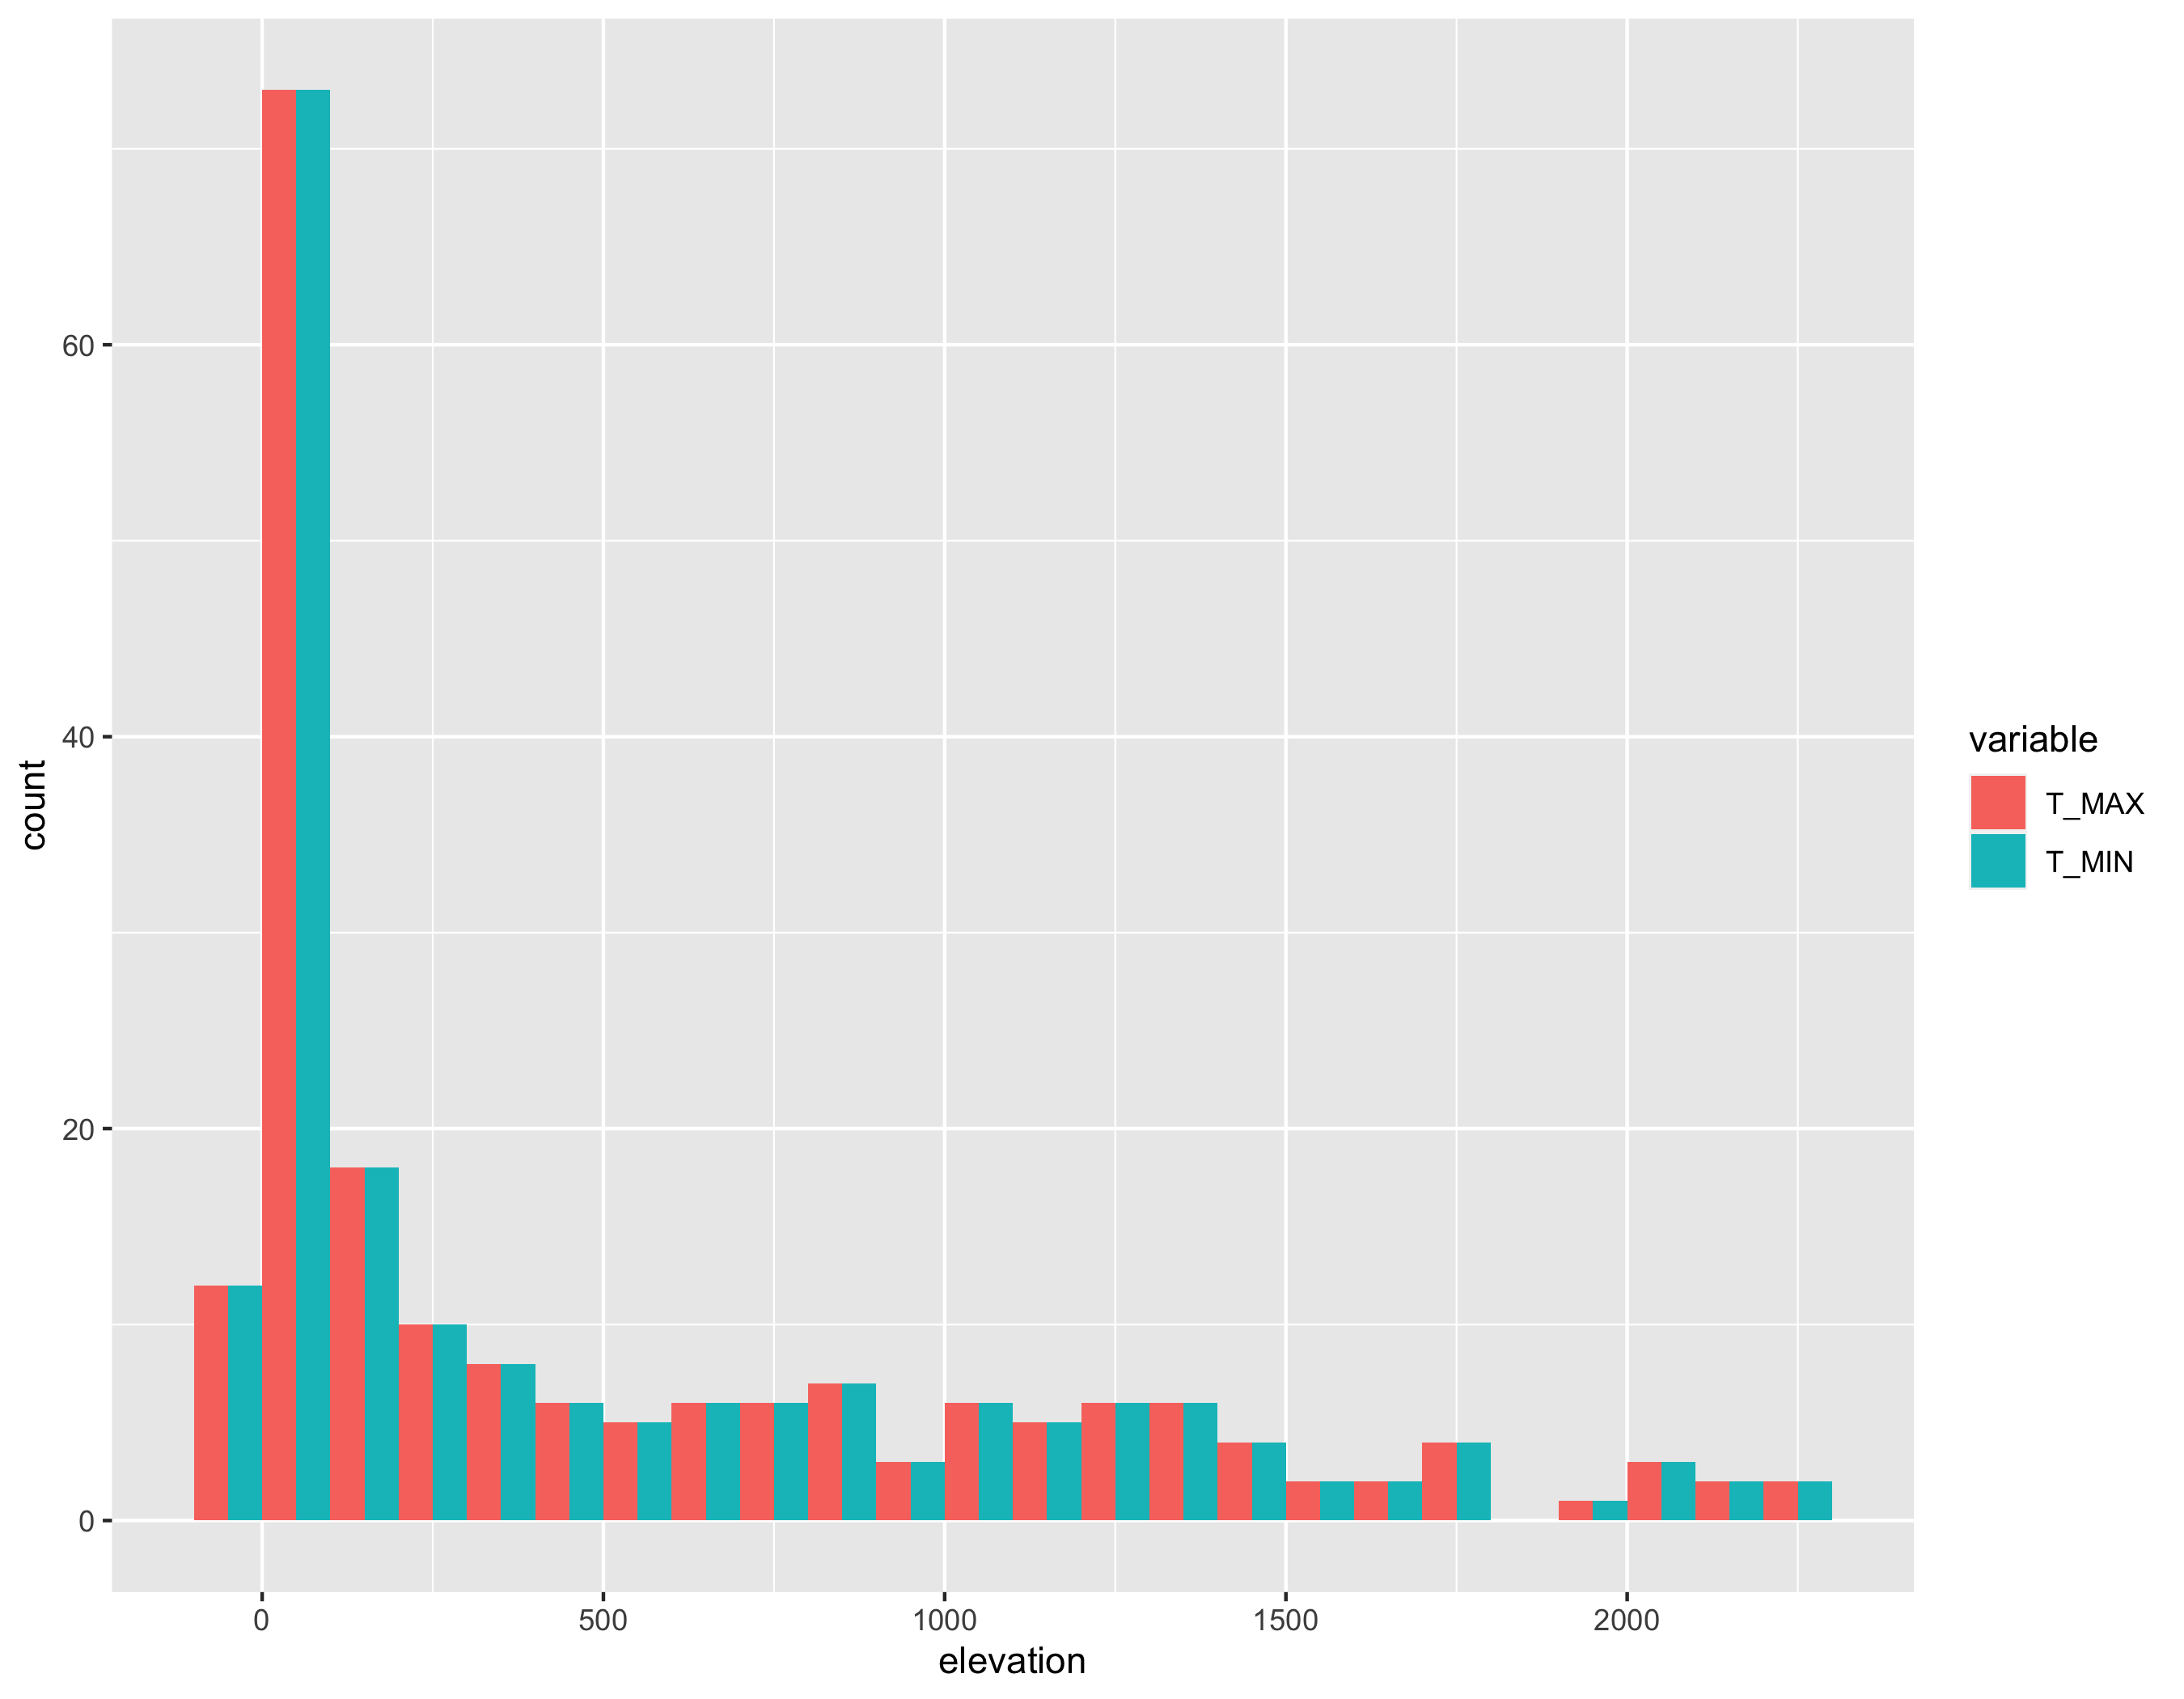

In [26]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())